# Q1

# Cutout regularization aims to use both the advantages from dropout as well as the advantages of data augmenation with regards to regularization. It is a regularization technique applied to convolutional neural neworks where we remove neighboring parts of input images and also augmente the dataset with obstructed versions of existing samples. The idea is to extend the dropout in the sense that we also apply a spatial prior that is relevant for images data as images share local connectivities. The ultimate goal is to force the learning algorithm to get a global sense of the full image rather than learning specific features that might endanger the predictions on unseen data where those features are not present. Finally, the key difference with dropout is that cutout is applied to the input layer so that visual features are removed directly from the image and no dropout is applied in the hidden layer and therefore the image itself is modified which makes cutout similar to dropout.


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras import models, layers
import tensorflow.keras as keras
from tensorflow.keras.layers import BatchNormalization, LayerNormalization
import tensorflow as tf
from tensorflow.keras.layers import Dropout
import numpy as np
import matplotlib.pyplot as plt
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
from matplotlib import pyplot
from tensorflow.keras.datasets import cifar10  
from numpy import save
from numpy import savetxt
from numpy import loadtxt
from time import time
import pandas as pd



from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import numpy as np
import os
import math
import numpy as np
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
from numpy import savetxt
from numpy import loadtxt

/Users/taziy/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/taziy/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/taziy/anaconda3/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/taziy/anaconda3/lib/python3.7/site-packages/tensorboar

Please install GPU version of TF


In [ ]:
def apply_mask(image, size=12, n_squares=1):
    h, w, channels = image.shape
    new_image = image
    for _ in range(n_squares):
        y = np.random.randint(h)
        x = np.random.randint(w)
        y1 = np.clip(y - size // 2, 0, h)
        y2 = np.clip(y + size // 2, 0, h)
        x1 = np.clip(x - size // 2, 0, w)
        x2 = np.clip(x + size // 2, 0, w)
        new_image[y1:y2,x1:x2,:] = 0
    return new_image

170500096/170498071 [==============================] - 13s 0us/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Original images:


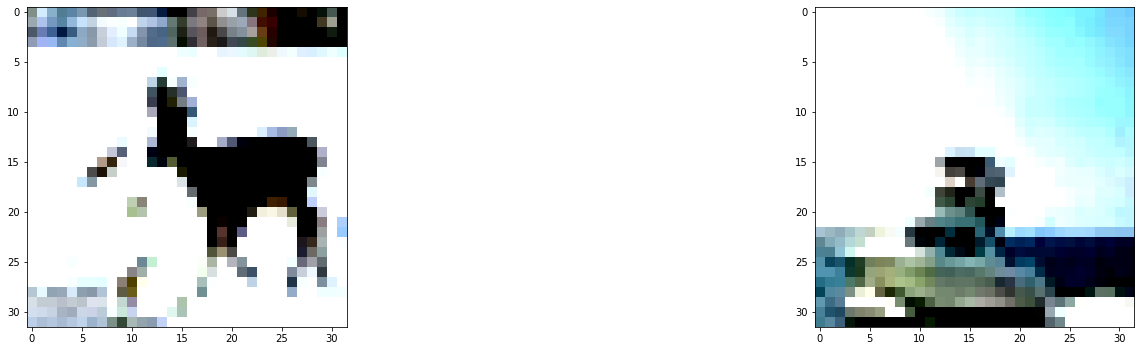

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Images with cutout:


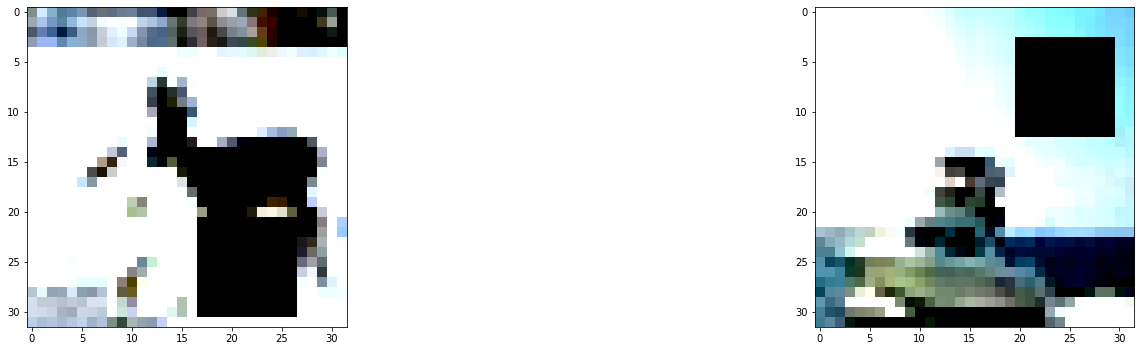

In [ ]:

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
# Data normalization
m, std = np.mean(x_train), np.std(x_train)
x_train = (x_train - m)/std
x_test = (x_test - m)/std
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)
plt.figure(figsize=(40,20))
print("Original images:")
images_index = [20,100]
for i in range(2):
    tmp = x_train[images_index[i]]
    plt.subplot(330 + 1 + i)
    plt.imshow(tmp)
plt.show()
print("Images with cutout:")
plt.figure(figsize=(40,20))
for i in range(2):
    tmp = x_train[images_index[i]]
    plt.subplot(330 + 1 + i)
    plt.imshow(apply_mask(tmp,size=10))
plt.show()

# Q2

In [ ]:
# training parameters
batch_size = 64 
epochs =100
data_augmentation = True
num_classes = 10

# subtracting pixel mean improves accuracy
subtract_pixel_mean = True
n = 7 # so that we use resnet 44 because 6*n+2
depth = n * 6 + 2


# model name, depth and version
model_type = 'ResNet44'

# load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)


def lr_schedule(epoch):
    lr = 1e-3 if epoch <80 else 1e-4
    return lr


def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):

    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, in [a])')
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            # first layer but not first stack
            if stack > 0 and res_block == 0:  
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            # first layer but not first stack
            if stack > 0 and res_block == 0:
                # linear projection residual shortcut
                # connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model



model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=lr_schedule(0)),
              metrics=['acc'])
model.summary()


# prepare model model saving directory.
save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'cifar10_%s_model.{epoch:03d}.h5' % model_type
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# prepare callbacks for model saving and for learning rate adjustment.
checkpoint = ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = LearningRateScheduler(lr_schedule)

lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                               cooldown=0,
                               patience=5,
                               min_lr=0.5e-6)

callbacks = [checkpoint, lr_reducer, lr_scheduler]

# run training, with or without data augmentation.

print('With data augmentation')
datagen = ImageDataGenerator(featurewise_center=False,samplewise_center=False,featurewise_std_normalization=False,
                             samplewise_std_normalization=False,zca_whitening=False,rotation_range=0,width_shift_range=0.1,height_shift_range=0.1,horizontal_flip=True,vertical_flip=False)

datagen.fit(x_train)

steps_per_epoch =  math.ceil(len(x_train) / batch_size)
# fit the model on the batches generated by datagen.flow().
history = model.fit(x=datagen.flow(x_train, y_train, batch_size=batch_size),
          verbose=1,
          epochs=epochs,
          validation_data=(x_test, y_test),  ### Testing is done with original images.
          steps_per_epoch=steps_per_epoch,
          callbacks=callbacks)


# score trained model
scores = model.evaluate(x_test,
                        y_test,
                        batch_size=batch_size,
                        verbose=0)
print('Validation loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

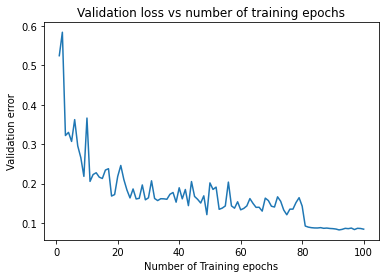

In [ ]:
plt.plot(range(1,101),history.history['val_loss'])[1-el for el in l]
plt.plot(range(1,101),[1-val_acc for val_acc in history.history['val_acc']])
plt.xlabel("Number of Training epochs")
plt.ylabel("Validation error")
plt.title("Validation loss vs number of training epochs")
plt.savefig("val_error_without_cutout.png")
plt.show()

# Q3

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
def batch_generator(x, y, epochs, m, batch_size, augment=None):
    for _ in range(epochs):
        n = x.shape[0]
        reorder = np.random.permutation(n)
        cursor = 0
        while cursor + batch_size < x.shape[0]:
            x_batch = x[reorder[cursor:cursor+batch_size]]
            y_batch = y[reorder[cursor:cursor+batch_size]]
            if augment != None:
                yield np.array([augment(xx) for xx in x_batch for rep in range(m)]), np.array([yy for yy in y_batch for rep in range(m)])
            else:
                yield x_batch, y_batch
            cursor += batch_size


In [ ]:
val_acc_cutout_32 = []
epochs = 50
durations_32 = []
for m in [32]:#,4,8,16,32]:
    print("M = ",m)
    model = resnet_v1(
        input_shape=x_train.shape[1:],
        depth=44
    )      
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.RMSprop(),
        metrics=['accuracy']
    )    
    duration = time()
    hist = model.fit_generator(
        batch_generator(
            x_train,
            y_train,
            m=m,
            batch_size=64,
            epochs=epochs, 
            augment=apply_mask
        ),
        epochs=epochs, 
        validation_data=(x_test,y_test),
        steps_per_epoch=np.floor(x_train.shape[0]/64.0),
        verbose=1,
        callbacks=[lr_scheduler]
    )
    durations_32.append(time()-duration)
    val_acc_cutout_32.append(hist.history['val_accuracy'])
    savetxt(F"/content/gdrive/My Drive/val_acc_cutout_32.csv", val_acc_cutout_32, delimiter=',')
    savetxt(F"/content/gdrive/My Drive/durations_32.csv", durations_32, delimiter=',')

M =  32
Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/50
781/781 [==============================] - 829s 1s/step - loss: 2.4523 - accuracy: 0.1838 - val_loss: 8.8941 - val_accuracy: 0.1322
Epoch 2/50
781/781 [==============================] - 830s 1s/step - loss: 2.2384 - accuracy: 0.2145 - val_loss: 4.9183 - val_accuracy: 0.1734
Epoch 3/50
781/781 [==============================] - 829s 1s/step - loss: 2.1764 - accuracy: 0.2276 - val_loss: 6.6778 - val_accuracy: 0.2332
Epoch 4/50
781/781 [==============================] - 829s 1s/step - loss: 2.1453 - accuracy: 0.2322 - val_loss: 2.5713 - val_accuracy: 0.2711
Epoch 5/50
781/781 [==============================] - 829s 1s/step - loss: 2.1269 - accuracy: 0.2397 - val_loss: 2.1092 - val_accuracy: 0.3123
Epoch 6/50
781/781 [==============================] - 828s 1s/step - loss: 2.1124 - accuracy: 0.2445 - val_loss: 2.4620 - val_accuracy: 0.3150
Epoch 7/50
781/781 [==============================] - 828s

In [ ]:

val_acc_cutout_16 = []
epochs = 50
durations_16 = []
for m in [16]:#,4,8,16,32]:
    print("M = ",m)
    model = resnet_v1(
        input_shape=x_train.shape[1:],
        depth=44
    )      
    model.compile(
        loss='categorical_crossentropy',
        optimizer=tf.keras.optimizers.RMSprop(),
        metrics=['accuracy']
    )    
    duration = time()
    hist = model.fit_generator(
        batch_generator(
            x_train,
            y_train,
            m=m,
            batch_size=64,
            epochs=epochs, 
            augment=apply_mask
        ),
        epochs=epochs, 
        validation_data=(x_test,y_test),
        steps_per_epoch=np.floor(x_train.shape[0]/64.0),
        verbose=1,
        callbacks=[lr_scheduler]
    )
    durations_16.append(time()-duration)
    val_acc_cutout_16.append(hist.history['val_accuracy'])
    savetxt(F"/content/gdrive/My Drive/val_acc_cutout_16.csv", val_acc_cutout_16, delimiter=',')
    savetxt(F"/content/gdrive/My Drive/durations_16.csv", durations_16, delimiter=',')

M =  16
Epoch 1/50
781/781 [==============================] - 351s 449ms/step - loss: 2.3246 - accuracy: 0.2588 - val_loss: 2.2616 - val_accuracy: 0.3234
Epoch 2/50
781/781 [==============================] - 350s 449ms/step - loss: 2.0490 - accuracy: 0.3229 - val_loss: 2.1283 - val_accuracy: 0.3616
Epoch 3/50
781/781 [==============================] - 350s 449ms/step - loss: 1.9408 - accuracy: 0.3497 - val_loss: 2.0421 - val_accuracy: 0.3785
Epoch 4/50
781/781 [==============================] - 350s 448ms/step - loss: 1.8649 - accuracy: 0.3729 - val_loss: 2.7860 - val_accuracy: 0.3220
Epoch 5/50
781/781 [==============================] - 350s 448ms/step - loss: 1.8232 - accuracy: 0.3830 - val_loss: 2.3621 - val_accuracy: 0.3577
Epoch 6/50
781/781 [==============================] - 350s 448ms/step - loss: 1.7854 - accuracy: 0.3984 - val_loss: 1.6221 - val_accuracy: 0.4752
Epoch 7/50
781/781 [==============================] - 350s 448ms/step - loss: 1.7637 - accuracy: 0.4010 - val_loss: 

In [14]:
cutout2_data = loadtxt("val_acc_cutout_2.csv",delimiter=",")
cutout4_data = loadtxt("val_acc_cutout_4.csv",delimiter=",")
cutout8_data = loadtxt("val_acc_cutout_8.csv",delimiter=",")
cutout16_data = loadtxt("val_acc_cutout_16.csv",delimiter=",")
cutout32_data = loadtxt("val_acc_cutout_32.csv",delimiter=",")

durations2_data = loadtxt("durations_2.csv",delimiter=",")
durations4_data = loadtxt("durations_4.csv",delimiter=",")
durations8_data = loadtxt("durations_8.csv",delimiter=",")
durations16_data = loadtxt("durations_16.csv",delimiter=",")
durations32_data = loadtxt("durations_32.csv",delimiter=",")

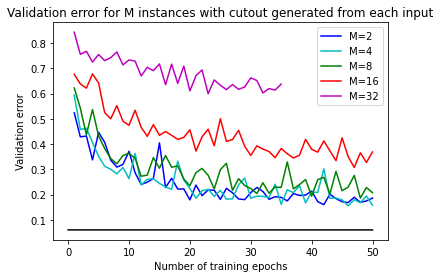

In [13]:
def val_error(val):
    return [1-v for v in val]

plt.plot(range(1,51),val_error(cutout2_data),"b-")
plt.plot(range(1,51),val_error(cutout4_data),"c-")
plt.plot(range(1,51),val_error(cutout8_data),"g-")
plt.plot(range(1,51),val_error(cutout16_data),"r-")
plt.plot(range(1,36),val_error(cutout32_data),"m-")
plt.xlabel("Number of training epochs")
plt.ylabel("Validation error")
plt.legend(["M=2","M=4","M=8","M=16","M=32"])
plt.plot(np.linspace(0,50,10000),[0.06]*10000,"k-")
plt.title("Validation error for M instances with cutout generated from each input")
#plt.savefig("val_error_with_cutout.png")
plt.show()

In [20]:
print (" M=2 Time to train 50 epochs :", durations2_data,"\n")
print (" M=4 Time to train 50 epochs :", durations4_data,"\n")
print (" M=8 Time to train 50 epochs :", durations8_data,"\n")
print (" M=16 Time to train 50 epochs :", durations16_data,"\n")
print (" M=32 Time to train 35 epochs :", durations32_data,"\n")

 M=2 Time to train 50 epochs : 2766.2118268013 

 M=4 Time to train 50 epochs : 4897.306997060776 

 M=8 Time to train 50 epochs : 9115.753979206085 

 M=16 Time to train 50 epochs : 17399.752579927444 

 M=32 Time to train 35 epochs : 23586.50715637207 



## I could not train them for 100 epochs as I got runtime error on both colab and Jupytherhub but  I trained them for 50 epochs for M=2 to 16 and 35 epochs for M=32.